In [5]:
####Rene 7_30_2021 update 4/1/2022
# Import the os module
import os
import pandas as pd
import numpy as np

#This file is for development. Main functions are embedded here.

#Isotope pattern matching algorithm for LC-FTMS Data
# Change the current working directory
os.chdir('/Users/boiteaur/Desktop/CoreMS_metallomics/CoreMS')

###### Settings for pattern mining
timerange=(5,25) #in minutes
peakwidth=0.25 #in minutes
interval=0.5 #
slope_filter=(0.5,2) # normalized slope (1=true)
correlation=0.7 #minimum r-squared correlation cut-off. 

mass_tolerance=0.001
ratio_tolerance=1.3

###### Set file folder and THERMO RAW file name here:
file_location='/Users/boiteaur/Desktop/Major projects/Bermuda Atlantic Time Series data processing/Thermo RAW data'
files=os.listdir('/Users/boiteaur/Desktop/Major projects/Bermuda Atlantic Time Series data processing/Thermo RAW data')

#####Set isotope pattern using atom.epattern. Just requires elements and max number of isotopes used
element='Cu'
nisotope_used=2
valence=2

save_file="_"+element

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("./")

from pathlib import Path

import matplotlib.pyplot as plt
# from PySide2.QtWidgets import QFileDialog, QApplication
# from PySide2.QtCore import Qt

from corems.mass_spectra.input import rawFileReader
from corems.molecular_id.factory.classification import HeteroatomsClassification, Labels
from corems.molecular_id.search.priorityAssignment import OxygenPriorityAssignment
from corems.molecular_id.search.molecularFormulaSearch import SearchMolecularFormulas
from corems.encapsulation.factory.parameters import MSParameters

import matplotlib.backends.backend_pdf
from support_code import isotope_pattern as ip
from support_code import AtomsDescription_standardized as atom

#Set peak detection threshold method
MSParameters.mass_spectrum.threshold_method = 'signal_noise'
MSParameters.mass_spectrum.s2n_threshold = 2
MSParameters.ms_peak.peak_min_prominence_percent = 0.001

MSParameters.molecular_search.error_method = 'None'
MSParameters.molecular_search.min_ppm_error = -2
MSParameters.molecular_search.max_ppm_error = 2

MSParameters.molecular_search.url_database = None
MSParameters.molecular_search.min_dbe = 0
MSParameters.molecular_search.max_dbe = 16

MSParameters.molecular_search.usedAtoms['C'] = (1,50)
MSParameters.molecular_search.usedAtoms['H'] = (4,80)
MSParameters.molecular_search.usedAtoms['O'] = (1,15)
MSParameters.molecular_search.usedAtoms['N'] = (0,10)
MSParameters.molecular_search.usedAtoms['S'] = (0,0)
MSParameters.molecular_search.usedAtoms[element] = (0,1)

MSParameters.molecular_search.isProtonated = True
MSParameters.molecular_search.isRadical = False
MSParameters.molecular_search.isAdduct = False

MSParameters.molecular_search.score_method = "prob_score"
MSParameters.molecular_search.output_score_method = "prob_score"

In [6]:
#Read in sample list and load MS data

samplelist=pd.read_csv(file_location+'/'+'BATS_samplelist.csv')

MSfiles={}
for file in samplelist.File:
    parser = rawFileReader.ImportMassSpectraThermoMSFileReader(file_location+'/'+file)
    MSfiles[file]=parser

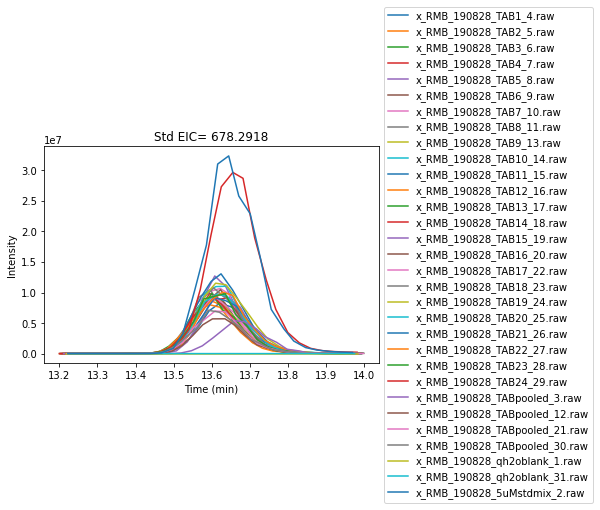

22
pass of
23
11.0 % std dev


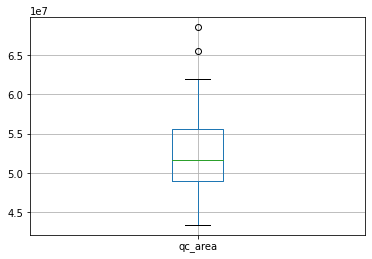

In [7]:
#QC control 

stdmass=678.2918
std_timerange=[13.2,14]


area=[]
rt=[]
fig=plt.figure()
ax=plt.subplot(111)
ax.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass))

for file in samplelist.File:
    EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
    df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
    df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
    area.append(sum(df_sub['EIC']))
    rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
    ax.plot(df_sub['time'],df_sub['EIC'],label=file)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

samplelist['qc_area']=area
samplelist['qc_rt']=rt

plt.show()

peak_stdv=samplelist[samplelist.type=='sample'].qc_area.std()
peak_mean=samplelist[samplelist.type=='sample'].qc_area.mean()

samplelist[samplelist.type=='sample'].boxplot(column=['qc_area'])

samplelist['qc_pass']=0
for i in samplelist.index:
    if (abs(samplelist.qc_area[i]-peak_mean)<2*peak_stdv):
        samplelist.qc_pass[i]=1

print(samplelist[samplelist.type=='sample'].qc_pass.sum())
print('pass of')
print(len(samplelist[samplelist.type=='sample']))

peak_stdv=samplelist[samplelist.qc_pass==1].qc_area.std()
peak_mean=samplelist[samplelist.qc_pass==1].qc_area.mean()

print(str(round(peak_stdv/peak_mean*100,1))+' % std dev')

In [8]:
#### Core feature extraction function.
pattern=atom.epattern(element,2,atom.atoms)
print(pattern)
masterresults=[]
allresults=[]

for file in MSfiles:
    print(file)
    results=MSfiles[file].isotopehunter(pattern,timerange,mass_tolerance,ratio_tolerance,peakwidth,correlation,slope_filter)
    if(results[0]):
        for result in results[0]:
            print(type(result))
            result['file']=file
        masterresults.extend(results[0])

print(pd.DataFrame(masterresults))

pd.DataFrame(masterresults).to_csv(file_location+'BATS_masterresults_Cu.csv')

  isotope       mass  abundance element requirement     mdiff     ratio
0    63Cu  62.929598   0.691515      Cu           Y  0.000000  1.000000
1    65Cu  64.927790   0.308515      Cu           Y  1.998192  0.446144
x_RMB_190828_TAB1_4.raw
Scan:347 Time (min): 5.02
27
Scan:363 Time (min): 5.26
48
Scan:381 Time (min): 5.52
30
Scan:399 Time (min): 5.78
26
Scan:415 Time (min): 6.0
37
Scan:433 Time (min): 6.26
33
Scan:451 Time (min): 6.52
30
Scan:467 Time (min): 6.75
39
Scan:485 Time (min): 7.01
40
Scan:503 Time (min): 7.26
26
Scan:521 Time (min): 7.53
43
Scan:537 Time (min): 7.75
64
Scan:555 Time (min): 8.01
56
Scan:573 Time (min): 8.27
96
Scan:591 Time (min): 8.52
105
Scan:607 Time (min): 8.75
105
Scan:625 Time (min): 9.0
76
Scan:643 Time (min): 9.25
87
Scan:661 Time (min): 9.51
40
Scan:679 Time (min): 9.77
45
Scan:697 Time (min): 10.02
28
Scan:715 Time (min): 10.27
91
Scan:733 Time (min): 10.52
73
Scan:751 Time (min): 10.78
58
Scan:767 Time (min): 11.0
75
Scan:785 Time (min): 11.25
46
S

In [9]:
print(pd.DataFrame(masterresults))

pd.DataFrame(masterresults).to_csv(file_location+'BATS_masterresults_Cu.csv')

                                                  scan       time  \
0    [1611, 1613, 1615, 1617, 1619, 1621, 1623, 162...  22.760320   
1    [1630, 1632, 1634, 1636, 1638, 1640, 1642, 164...  23.016455   
2    [1135, 1137, 1139, 1141, 1143, 1145, 1147, 114...  16.517972   
3        [609, 611, 613, 615, 617, 619, 621, 623, 625]   9.500383   
4    [1021, 1023, 1025, 1027, 1029, 1031, 1033, 103...  15.256903   
..                                                 ...        ...   
266   [1327, 1328, 1330, 1332, 1333, 1335, 1337, 1339]  24.020688   
267           [698, 700, 702, 704, 706, 708, 710, 712]  11.768462   
268           [895, 897, 899, 901, 903, 905, 907, 909]  14.769582   
269           [895, 897, 899, 901, 903, 905, 907, 909]  14.769582   
270           [895, 897, 899, 901, 903, 905, 907, 909]  14.769582   

                                                  63Cu  \
0    {'mz': 798.7177838889588, 'intense': 252831.74...   
1    {'mz': 497.311230796523, 'intense': 357713.457... 

                                                scan       time  \
0  [1611, 1613, 1615, 1617, 1619, 1621, 1623, 162...  22.760320   
1      [834, 836, 838, 840, 842, 844, 846, 848, 850]  12.001010   
2  [1749, 1751, 1753, 1755, 1757, 1759, 1761, 176...  24.752102   
3  [1648, 1650, 1652, 1654, 1656, 1658, 1660, 166...  23.524750   

                                                63Cu  \
0  {'mz': 798.7177838889588, 'intense': 252831.74...   
1  {'mz': 521.003044973907, 'intense': 136714.510...   
2  {'mz': 791.8881511005073, 'intense': 105929.55...   
3  {'mz': 503.33053001910605, 'intense': 177461.7...   

                                                65Cu      corr  \
0  {'mz': 800.7156891328806, 'intense': 102234.70...  0.942229   
1  {'mz': 523.001004162937, 'intense': 63941.8667...  0.890857   
2  {'mz': 793.8861257450927, 'intense': 53960.724...  0.774881   
3  {'mz': 505.3277446079433, 'intense': 69186.961...  0.836133   

                        file     slope     mass     

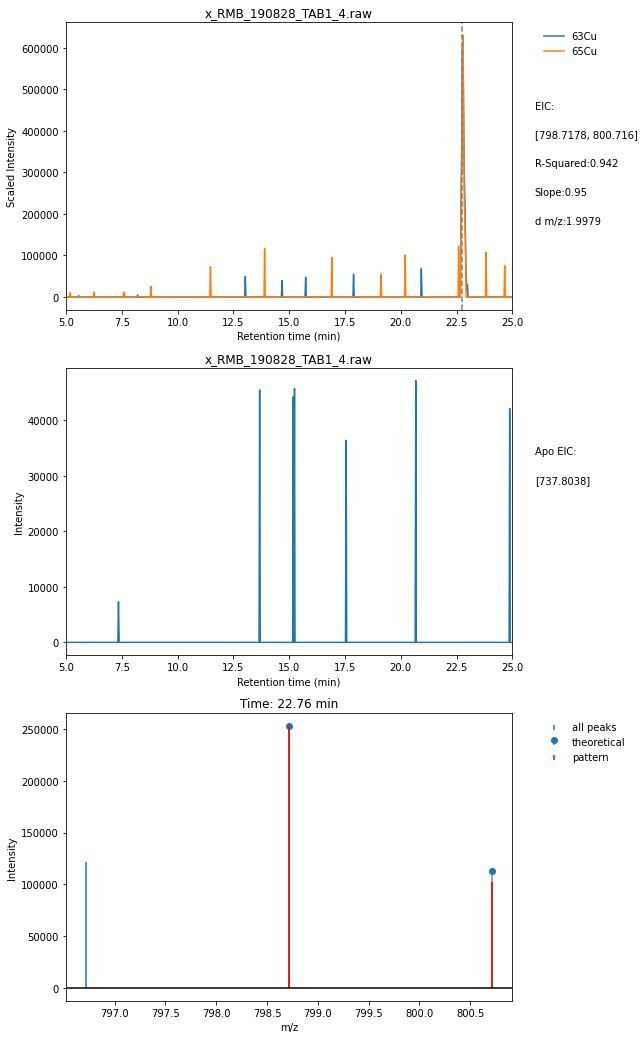

{'mz': 521.003044973907, 'intense': 136714.5101362111}


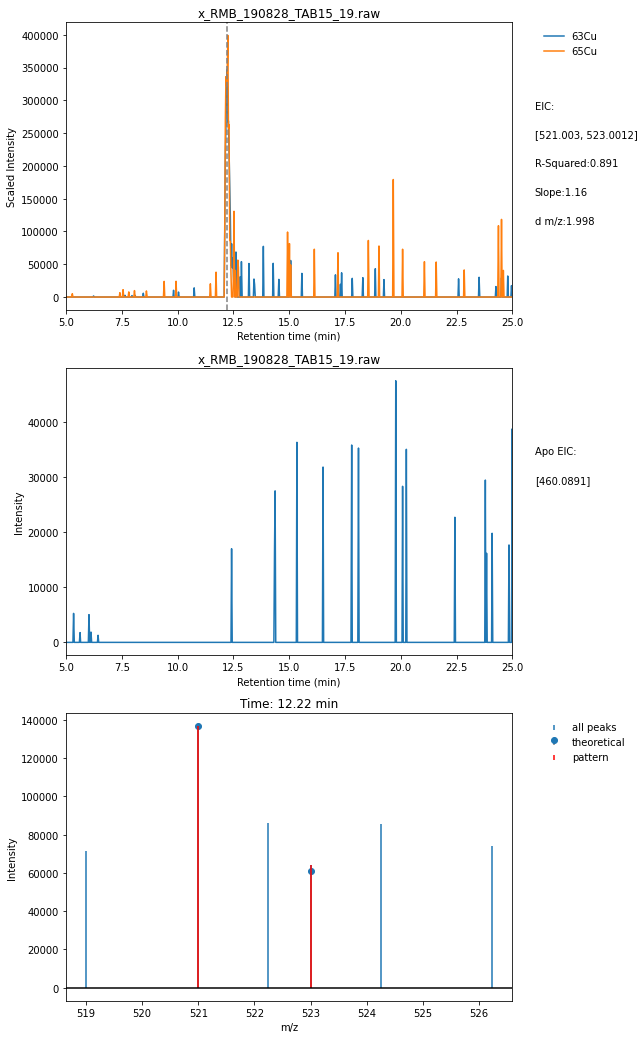

{'mz': 791.8881511005073, 'intense': 105929.55777210057}


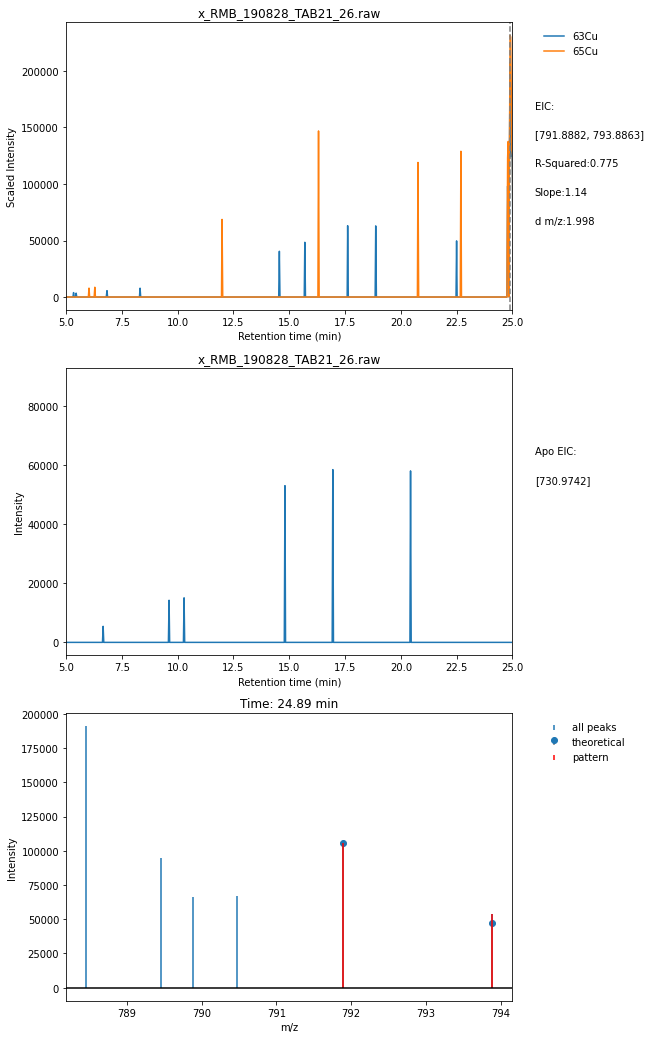

{'mz': 503.33053001910605, 'intense': 177461.7585927112}


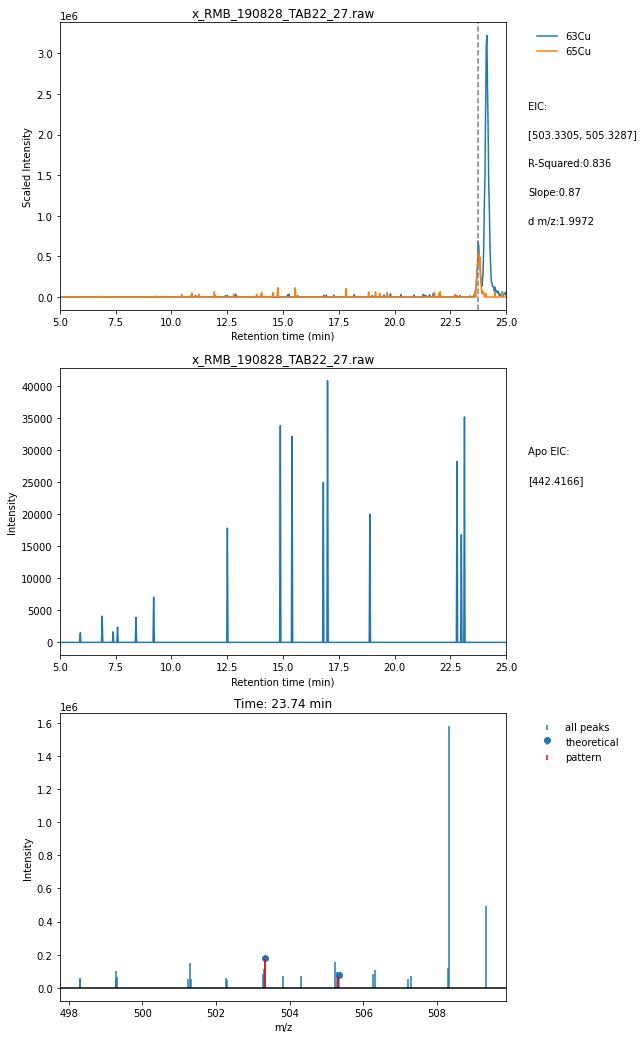

In [10]:
allresults=[]
master_df=pd.DataFrame(masterresults)
master_df=master_df[master_df.qc=='max']

for result in masterresults:
    if(result['qc']=='max'):
        masses=master_df[(abs(master_df.mass-result['mass']) < mass_tolerance) & (abs(master_df.time - result['time']) < peakwidth*2)]
        max_value=max(masses.abundance_peak)

        if(result['abundance_peak']==max_value):
            allresults.append(result)

print(pd.DataFrame(allresults)) 

for result in allresults:
    filename=result['file']
    currfile=MSfiles[filename]
    print(result['63Cu'])
    fig, (ax1,ax2,ax3) = plt.subplots(3,1)
    fig.set_size_inches(8,18)
    ip.metal_chromatogram(ax1,currfile,result,pattern,timerange,filename)
    ip.apoplot(ax2,currfile,result,pattern,timerange,filename,2)
    ip.MS_pattern_plot(ax3,currfile,result,pattern)
    plt.show()

#plt.show()


[{'mass': 798.718, 'time': 22.76032}, {'mass': 521.003, 'time': 12.224968333333333}, {'mass': 791.888, 'time': 24.892128333333332}, {'mass': 503.331, 'time': 23.74458166666667}]


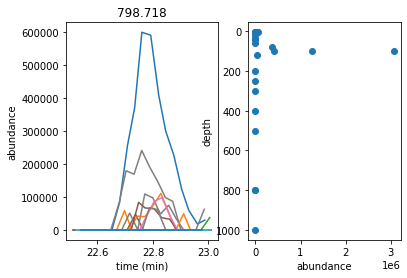

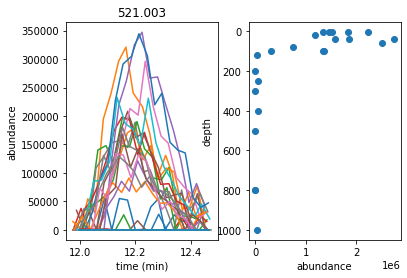

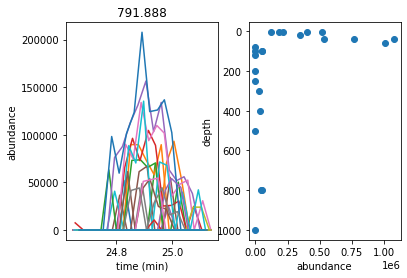

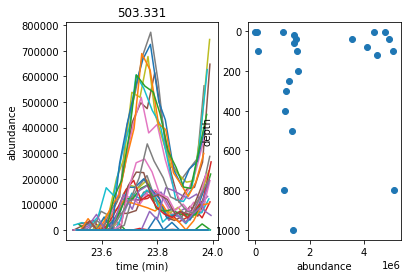

In [27]:
#Plot profile of Pattern matched features:

EIC_masses=[]

for result in allresults:
    EIC_masses.append({'mass':result['mass'],'time':result['time_peak']})

print(EIC_masses)

for i in EIC_masses:
    mass=i['mass']
    time=i['time']
    fig, (ax1,ax2) = plt.subplots(1,2)
    ax1.set(xlabel='time (min)',ylabel='abundance',title=mass)
    ax2.set(xlabel='abundance',ylabel='depth')
    ax2.invert_yaxis()
    peak_areas=[]
    for file in samplelist.File:
        EIC=MSfiles[file].get_eics(target_mzs=[mass],tic_data={},peak_detection=False,smooth=False)
        df=pd.DataFrame({'EIC':EIC[0][mass].eic,'time':EIC[0][mass].time})
        df_sub=df[df['time'].between(time-peakwidth,time+peakwidth)]
        area=(sum(df_sub['EIC']))
        peak_areas.append(area)
        ax1.plot(df_sub['time'],df_sub['EIC'],label=file)
    samplelist[mass]=peak_areas
    ax2.scatter(samplelist[mass],samplelist.Depth)
    plt.show()


stdmass=678.2918
std_timerange=[13.2,14]


area=[]
rt=[]
fig=plt.figure()
ax=plt.subplot(111)
ax.set(xlabel='Time (min)',ylabel='Intensity',title='Std EIC= '+str(stdmass))

for file in samplelist.File:
    EIC=MSfiles[file].get_eics(target_mzs=[stdmass],tic_data={},peak_detection=False,smooth=False)
    df=pd.DataFrame({'EIC':EIC[0][stdmass].eic,'time':EIC[0][stdmass].time})
    df_sub=df[df['time'].between(std_timerange[0],std_timerange[1])]
    area.append(sum(df_sub['EIC']))
    rt.append(df_sub.time[df_sub.EIC==df_sub.EIC.max()].max())
    ax.plot(df_sub['time'],df_sub['EIC'],label=file)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

samplelist['qc_area']=area
samplelist['qc_rt']=rt


In [ ]:
pdf = matplotlib.backends.backend_pdf.PdfPages(file_location+file_name+save_file+'.pdf')

pdf = matplotlib.backends.backend_pdf.PdfPages(file_location+file_name+save_file+'.pdf')

#Generate plots:
pdf.savefig(ip.isotopehunter_qc_plots(results,pattern,file_name,correlation),dpi=200,bbox_inches='tight')

#ip.isotopehunter_qc_plots(results,pattern,file_name,correlation)

for result in results[2]:
    fig, (ax1,ax2,ax3) = plt.subplots(3,1)
    fig.set_size_inches(8,18)
    ip.metal_chromatogram(ax1,parser,result,pattern,timerange,file_name)
    ip.apoplot(ax2,parser,result,pattern,timerange,file_name,2)
    ip.MS_pattern_plot(ax3,parser,result,pattern)
    pdf.savefig(fig,dpi=200,bbox_inches='tight')

pdf.close()

#Print data out. 
pd.DataFrame(results[2]).to_csv(file_location+file_name+save_file+'.csv')

print('end')

In [ ]:
#creating a dataframe
peak_area = pd.read_csv("nrc_220314_samples_peakareas.csv")
concentration = pd.read_csv("nrc_220314_Samples_ConcentrationsuM.csv")
#Subset of Cobalt peak areas, should be consistent among all samples. 
co_pa = peak_area.loc[:,'pa_59Co']

# #Creating a boxplot based on peak areas 
red_circle = dict(markerfacecolor='red', marker='o')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')
plt.boxplot(x=peak_area['pa_59Co'], vert=False, flierprops=red_circle, showmeans=True, meanprops=mean_shape)  
plt.xlabel('Peak Area of B12')
plt.ylabel('Samples')
plt.title('Boxplot of Internal Standard Distribution')
plt.show()

##Creating a boxplot based on concentrations
red_circle = dict(markerfacecolor='red', marker='o')
mean_shape = dict(markerfacecolor='green', marker='D', markeredgecolor='green')
plt.boxplot(x=concentration['uMCo'], vert=False, flierprops=red_circle, showmeans=True, meanprops=mean_shape)  
plt.xlabel('Peak Area of B12')
plt.ylabel('Samples')
plt.title('Boxplot of Internal Standard Distribution')
plt.show()

In [ ]:
#pattern=atom.ipattern(isotopes,requirement,atom.atoms)
pattern=atom.epattern(element,2,atom.atoms)
print(pattern)

In [ ]:
results=parser.isotopehunter(pattern,timerange,mass_tolerance,ratio_tolerance,peakwidth,correlation,slope_filter)

In [ ]:
print(pd.DataFrame(results[0]))

In [ ]:
EIC=parser.get_eics(target_mzs=[381],tic_data={},peak_detection=False,smooth=False)
df=pd.DataFrame({'mz1':EIC[0][381].eic,'time':EIC[0][381].time})

peakmax_i=df.mz1.max()
peakmax_t=df.time[df.mz1==peakmax_i]

print(peakmax_i)
print(peakmax_t.max())

In [ ]:
#Assign molecular formula.
for result in results[2]:
    ip.metal_assignment(parser,result,pattern,file_name)

In [ ]:

#Generate plots:
#ip.isotopehunter_qc_plots(results,pattern,file_name,correlation)


for result in results[2]:
    fig, (ax1,ax2,ax3) = plt.subplots(3,1)
    fig.set_size_inches(8,18)
    ip.metal_chromatogram(ax1,parser,result,pattern,timerange,file_name)
    ip.apoplot(ax2,parser,result,pattern,timerange,file_name,2)
    ip.MS_pattern_plot(ax3,parser,result,pattern)
    plt.show()

In [ ]:
print([results[2][0]['63Cu']['mz']])

In [ ]:
#Isotope pattern search function.

#Define the isotopic pattern boundaries based on 'pattern'. Results is a dictionary w/ key 'scan #s' containing a list of dictionaries w/ isotope patterns. 
def isotopehunter(lcms,pattern,timerange,mass_tolerance,ratio_tolerance,peakwidth,correlation,slope_filter):
    #Function matches required ('Y') peaks in pattern to spectra in lcms
    #Requires 'timerange','mass_tolerance','ratio_tolerance' for pattern matching
    #Requires 'pattern','peakwidth','correlation','slope_filter' for QC filtering

    #Define pattern boundaries
    umass=pattern.mdiff[pattern.requirement=='Y']+mass_tolerance
    lmass=pattern.mdiff[pattern.requirement=='Y']-mass_tolerance
    uratio=pattern.ratio[pattern.requirement=='Y']*ratio_tolerance
    lratio=pattern.ratio[pattern.requirement=='Y']/ratio_tolerance
    nisotope=len(umass)

    #Retrieve TIC for MS1 scans only within timerange
    tic=lcms.get_tic(ms_type='MS')[0]
    tic_df=pd.DataFrame({'time': tic.time,'scan': tic.scans})
    scans=tic_df[tic_df.time.between(timerange[0],timerange[1])].scan.tolist()

    #Create  empty results dictionaries. Will be filed with {Scan: {1st peak:{mz,intense}, 2nd peak:{mz,intense}, npeak:{mz,intense}}}
    results=[]
    clean_results=[]
    final_results=[]

    #Determine 2 most abundant isotopologues for correlation analysis.  
    req_isotopes=pattern[pattern.requirement=='Y'].isotope
    isotope1=req_isotopes[0]
    isotope2=req_isotopes[1]

    #Currently, this is a simple script that matches every peak in a spectra. In future, can speed up by looking at data subsets. 
        #mzint=20
        #mzbuffer=uppermass.iloc[-1]

    for s in scans:
        ms=lcms.get_average_mass_spectrum_by_scanlist([s])
        spectrum=pd.DataFrame({'mz':ms.mz_exp, 'intense':ms.abundance})
        #print(s)
        if(spectrum.shape[0]>2):
                    
            for j in spectrum.index:
                k=1
                hitlist=[]
                result={}

                while(k<nisotope):
                    hits=spectrum[(spectrum.mz > spectrum.mz[j]+lmass[k]) & (spectrum.mz < spectrum.mz[j]+umass[k]) & (spectrum.intense > spectrum.intense[j]*lratio[k]) & (spectrum.intense < spectrum.intense[j]*uratio[k])].index.tolist()
                    if hits:
                        hitlist.append(hits)
                        k=k+1
                    else:
                        k=nisotope+1
                if k==(nisotope):
                    result['scan']=s
                    result['time']=tic_df[tic_df.scan==s].time.iloc[0]

                    result[pattern.isotope[0]]={'mz':spectrum.mz[j],'intense':spectrum.intense[j]}

                    for i, iso in enumerate(req_isotopes[1:]):
                        #result[pattern.isotope[i]]={'mz':spectrum.mz[hitlist[i-1][0]],'intense':spectrum.intense[hitlist[i-1][0]]}
                        result[iso]={'mz':spectrum.mz[hitlist[i][0]],'intense':spectrum.intense[hitlist[i][0]]}
                    mass1=result[isotope1]['mz']
                    mass2=result[isotope2]['mz']

                    tstart=result['time']-peakwidth
                    tstop=result['time']+peakwidth

                    EIC=parser.get_eics(target_mzs=[mass1,mass2],tic_data={},peak_detection=False,smooth=False)
                    df=pd.DataFrame({'mz1':EIC[0][mass1].eic,'mz2':EIC[0][mass2].eic,'time':EIC[0][mass1].time})
                    df_sub=df[df['time'].between(tstart,tstop)]

                    #Calculate correlation and slope between two main isotopologues.        
                    corr=df_sub.corr(method='pearson').iat[0,1]**2
                    slope=np.polyfit(df_sub.mz1,df_sub.mz2,1)[0]/(pattern.sort_values(by='ratio',ascending=False).ratio[1]/pattern.sort_values(by='ratio',ascending=False).ratio[0])
                    result['corr']=corr
                    result['slope']=slope
                    result['mass']=round(mass1,3)
                    result['abundance']=result[isotope1]['intense']
                    result['qc']='match'

                    if corr>correlation:
                        if ((slope > slope_filter[0]) & (slope < slope_filter[1])):
                            clean_results.append(result)
                            result['qc']='qc'

                    results.append(result)

    clean_results_df=pd.DataFrame(clean_results)

    for result in clean_results:
        masses=clean_results_df[(abs(clean_results_df.mass-result['mass']) < mass_tolerance)& (abs(clean_results_df.time - result['time']) < peakwidth*2)]
        max_value=max(masses.abundance)

        if (result['abundance']==max_value):
            final_results.append(result)
            result['qc']='max'

    return(results,clean_results,final_results)   
    
results=isotopehunter(parser,pattern,timerange,mass_tolerance,ratio_tolerance,peakwidth,correlation,slope_filter)



In [ ]:
print(pd.DataFrame(results[0]))

In [ ]:
#Plot QC figures:

#First, plot mass error vs. ratio

def isotopehunter_qc_plots(results,file_name):
    mzdif=[]
    r_dif=[]
    qc=[]

    elementpatterns=pd.DataFrame(atom.get_elementpattern())

    #Determine 2 most abundant isotopologues for correlation analysis.  
    isotope1=pattern.sort_values(by='ratio',ascending=False).isotope[0]
    isotope2=pattern.sort_values(by='ratio',ascending=False).isotope[1]

    for result in results[0]:
        mzdif.append(result[isotope2]['mz']-result[isotope1]['mz'])
        r_dif.append(result[isotope2]['intense']/result[isotope1]['intense'])
        qc.append(result['qc'])
        result['dmz']=result[isotope2]['mz']-result[isotope1]['mz']

    plot_df=pd.DataFrame({'mzdif':mzdif,'rdif':r_dif,'qc':qc})
    clean_results=results[1]
    final_results=results[2]

    fig, (ax1,ax2,ax3) = plt.subplots(3,1)
    fig.set_size_inches(8,11)

    allcolor='lightgray'
    validcolor='black'
    maxcolor='red'
    ax1.scatter('mzdif','rdif',color=allcolor,data=plot_df)
    ax1.scatter('mzdif','rdif',color=validcolor,data=plot_df[plot_df.qc=='qc'])
    ax1.scatter('mzdif','rdif',color=maxcolor,data=plot_df[plot_df.qc=='max'])
    ax1.scatter('mdiff','ratio',color='blue',data=elementpatterns)
    for i, txt in enumerate(elementpatterns.element):
        ax1.annotate(txt, (elementpatterns.mdiff.iloc[i], elementpatterns.ratio.iloc[i]),color='blue')
    #ax1.scatter('mdiff','ratio',color='blue',data=pattern[pattern.isotope==isotope2])
    ax1.set(xlabel='m/z difference (Da)',ylabel='Ratio',title=file_name + ': '+ isotope2 + ' / ' + isotope1)
    ax1.set(xlim=[min(mzdif),max(mzdif)], ylim=[min(r_dif),max(r_dif)])
    ax1.legend(['all','valid','max','true'],bbox_to_anchor=(1.05, 1.0), loc='upper left')

    ax2.hist('corr',bins=np.arange(0,1,0.05),data=pd.DataFrame(results[0]),color=allcolor)
    ax2.hist('corr',bins=np.arange(0,1,0.05),data=pd.DataFrame(clean_results),color=validcolor)
    ax2.hist('corr',bins=np.arange(0,1,0.05),data=pd.DataFrame(final_results),color=maxcolor)
    ax2.legend(['all','valid','max'],bbox_to_anchor=(1.05, 1.0), loc='upper left')

    ax2.set(xlabel='R-squared',ylabel='Frequency')
    ax2.axvline(x=correlation, color='gray', linestyle='dashed')

    ax3.hist('slope',bins=20,data=pd.DataFrame(clean_results),color=validcolor)
    ax3.hist('slope',bins=20,data=pd.DataFrame(final_results),color=maxcolor)
    ax3.set(xlabel='Normalized Slope',ylabel='Frequency')
    ax3.legend(['valid','max'],bbox_to_anchor=(1.05, 1.0), loc='upper left')
    #ax2.axvline(x=correlation)
    return(fig)

isotopehunter_qc_plots(results,file_name)
plt.show()


In [ ]:
def isotope_result_plotter(result,lcms,pattern,file_name):
    
    #Determine 2 most abundant isotopologues for correlation analysis.  
    isotope1=pattern.sort_values(by='ratio',ascending=False).isotope[0]
    isotope2=pattern.sort_values(by='ratio',ascending=False).isotope[1]
    

    plotmasses=pattern.mdiff+result[isotope1]['mz']-pattern[pattern.isotope==isotope1].mdiff.iloc[0]

    eics=lcms.get_eics(target_mzs=plotmasses.to_list(),tic_data={},peak_detection=False,smooth=False)

    fig, (ax1,ax2) = plt.subplots(2,1)
    fig.set_size_inches(8,11)

    for i in plotmasses.index:
        ax1.plot(eics[0][plotmasses[i]].time, eics[0][plotmasses[i]].eic/pattern.ratio[i])
    ax1.set(xlabel='Retention time (min)',ylabel='Scaled Intensity',xlim=timerange)
    ax1.set_title(file_name)
    ax1.legend(pattern.isotope.to_list(),bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)
    ax1.text(1.05,0.7,'EIC:',transform=ax1.transAxes)
    ax1.text(1.05,0.6,plotmasses.round(4).to_list(),transform=ax1.transAxes)
    ax1.text(1.05,0.5,'R-Squared:'+ result['corr'].round(3).astype(str),transform=ax1.transAxes)
    ax1.text(1.05,0.4,'Slope:'+ result['slope'].round(2).astype(str),transform=ax1.transAxes)
    ax1.text(1.05,0.3,'d m/z:'+ result['dmz'].round(4).astype(str),transform=ax1.transAxes)
    ax1.axvline(x=result['time'],color='gray',linestyle='dashed')

    #What is faster way to get a scan?
    mass_spectrum=lcms.get_average_mass_spectrum_by_scanlist([result['scan']])

    #Get molecular formula of average mass spectrum. 

    mass_spectrum.molecular_search_settings.error_method = 'None'
    mass_spectrum.molecular_search_settings.min_ppm_error = -2
    mass_spectrum.molecular_search_settings.max_ppm_error = 2

    mass_spectrum.molecular_search_settings.url_database = None
    mass_spectrum.molecular_search_settings.min_dbe = 0
    mass_spectrum.molecular_search_settings.max_dbe = 16

    mass_spectrum.molecular_search_settings.usedAtoms['C'] = (1, 50)
    mass_spectrum.molecular_search_settings.usedAtoms['H'] = (4, 100)
    mass_spectrum.molecular_search_settings.usedAtoms['O'] = (1, 20)
    mass_spectrum.molecular_search_settings.usedAtoms['N'] = (0, 4)
    mass_spectrum.molecular_search_settings.usedAtoms['S'] = (0, 0)
    mass_spectrum.molecular_search_settings.usedAtoms['Cl'] = (0, 0)
    mass_spectrum.molecular_search_settings.usedAtoms['Br'] = (0, 0)
    mass_spectrum.molecular_search_settings.usedAtoms['P'] = (0, 0)
    mass_spectrum.molecular_search_settings.usedAtoms['Na'] = (0, 0)
    mass_spectrum.molecular_search_settings.usedAtoms['Fe'] = (0, 0)
    mass_spectrum.molecular_search_settings.usedAtoms['Cu'] = (0, 1)
    mass_spectrum.molecular_search_settings.usedAtoms['Zn'] = (0, 0)
    mass_spectrum.molecular_search_settings.usedAtoms['Ni'] = (0, 0)

    #for element in pattern.element:
    #    print(element)
    #    mass_spectrum.molecular_search_settings.usedAtoms[element] = (0,1)

    mass_spectrum.molecular_search_settings.isProtonated = True
    mass_spectrum.molecular_search_settings.isRadical = False
    mass_spectrum.molecular_search_settings.isAdduct = False


    # mass_spectrum.filter_by_max_resolving_power(15, 2)
    SearchMolecularFormulas(mass_spectrum, first_hit=False).run_worker_mass_spectrum()

    ms_df=mass_spectrum.to_dataframe()

    ms_df_range=ms_df[(abs(ms_df['m/z']-result['mass'])<6)]
    mf=ms_df_range[ms_df_range['m/z'].round(3)==result['mass']]['Molecular Formula'].iloc[0]
    error=ms_df_range[ms_df_range['m/z'].round(3)==result['mass']]['m/z Error (ppm)'].iloc[0]
    score=ms_df_range[ms_df_range['m/z'].round(3)==result['mass']]['Confidence Score'].iloc[0]

    result['Molecular Formula']=mf
    result['Error']=error
    result['Score']=score

    ax2.stem('m/z','Peak Height',data=ms_df_range,  markerfmt=' ', basefmt=' ')
    
    theor_mz=pattern.mdiff+result['mass']
    theor_int=pattern.ratio*result['abundance']
    ax2.stem(theor_mz,theor_int, basefmt=' ',linefmt='gray')

    for isotope in pattern.isotope[pattern.requirement=='Y']:
        ax2.stem('mz','intense',data=result[isotope],  markerfmt=' ', basefmt=' ',linefmt='red')


    ax2.legend(('all peaks','theoretical','pattern'),bbox_to_anchor=(1.05, 1.0), loc='upper left',frameon=False)
    ax2.set(xlabel='m/z',ylabel='Intensity')
    ax2.set_title('Time: '+result['time'].round(2).astype(str)+' min')
    ax2.text(1.05,0.7,mf,transform=ax2.transAxes)
    ax2.text(1.05,0.6,'Error (ppm) = '+round(error,3).astype(str),transform=ax2.transAxes)
    ax2.text(1.05,0.5,'Score = '+round(score,3).astype(str),transform=ax2.transAxes)
    ax2.axhline(y=0.0, color='black')

    return(fig)

import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages(file_location+file_name+'_63Cu.pdf')

pdf.savefig(isotopehunter_qc_plots(results,file_name),dpi=200,bbox_inches='tight')

for result in results[2]:
    pdf_fig=isotope_result_plotter(result,parser,pattern,file_name)
    pdf.savefig(pdf_fig,dpi=200,bbox_inches='tight')

pdf.close()
plt.show()